# Project goal

This part of the poject is focused on the covid-19 Italy analysis.
The goal list is the following:
<ul>
<li>visualization and analysis of the main indicators about the severity of the disease (confirmed deaths, confirmed cases, intensive care people, hospitalized people);</li>
<li>identify if there is a correlation about how the disease is spread in a country and features like population density;</li>
<li>identify if it is possible to predict when the emergency status is going to an end in the most impacted countries and countermeasures put in place (in example the lockdown of a province);</li>
</ul>

# Datasets

The datasets used in this italian part of the project are the following:
https://github.com/pcm-dpc/COVID-19

This dataset was chosen for two reasons:
<ul>
<li>It's really complete and up to date. Everyday a new entry is added, for provinces and regions.</li>
<li>There are information about everything, like number of tampons, deaths and even hospitilized people.</li>
</ul>   
The downside is that every day is a different file, so in the project every file is selected to generate a new dataset with everything inside and completely automated, taking every entry until the day before.

The other dataset is the following:
https://worldpopulationreview.com/countries/italy-population/cities/

This dataset contains up to date information about italian city population.
There are some missing entries about provinces, so it was necessary to add them manually in the dataset.
It is also badly formatted, resulting in a bad pandas scheme.
The dataset used is a manually modified version of this one.

Another useful dataset would be the density of the population by city, but was not available, so it has been created manually, using wikipedia information.
Since there are 107 provinces in Italy, the region population density was taken, because it's probably more significative than doing that for every single city, and it can be done in a reasonable amount of time.

# Libraries

In [1]:
import numpy as np
import os
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from datetime import date,timedelta
import copy
from statsmodels.tsa.arima_model import ARIMA

# Useful functions

Import utiliy functions.

In [2]:
yesterday = date.today() - timedelta(days=1)

date_list=pd.date_range(start="2020-02-24",end=yesterday) #time period from when the datasets starts until yesterday
str_date=[]
str_date_formatted=[]
#formatting the data to use it as a name of the columns of the new dataset and to use it for the github files
for i in range(len(date_list)):
    str_date.append(str(date_list[i]).replace("-", ""))
    str_date_formatted.append(str_date[i][:-9])

%run Utilities.ipynb

# Dataset rielaboration - Provinces

There are many csv files with shared information.
The following procedure is used to merge different datasets into a unique dataset.

Files are taken directly from the website of github. Everytime that new files are available, they are merged to the full dataset.

In [3]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province-'+str_date_formatted[0]+'.csv'
time_line_dataset = pd.read_csv(url)
del time_line_dataset['totale_casi']

for i in range(0,len(str_date_formatted)):
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province-'+str_date_formatted[i]+'.csv'    
    temp_data=pd.read_csv(url)
    time_line_dataset[str_date_formatted[i]]=temp_data['totale_casi']
 


Now let's remove empty data and delete the useless information.

NB: Naples has problems with NA, since the program things it's a NaN value. We have to decide how to manage this information in best possible way, but for now we modified it the in NAP.


In [4]:
time_line_dataset[time_line_dataset['denominazione_provincia'] == 'Napoli']

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,note_it,...,20200414,20200415,20200416,20200417,20200418,20200419,20200420,20200421,20200422,20200423
19,2020-02-24T18:00:00,ITA,15,Campania,63,Napoli,NaN,40.839566,14.25085,NaN,...,2010,2026,2072,2109,2130,2159,2181,2227,2263,2316


In [5]:
time_line_dataset.at[time_line_dataset[time_line_dataset['denominazione_provincia'] == 'Napoli'].index[0],'sigla_provincia']='NAP'
time_line_dataset[time_line_dataset['denominazione_provincia'] == 'Napoli']

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,note_it,...,20200414,20200415,20200416,20200417,20200418,20200419,20200420,20200421,20200422,20200423
19,2020-02-24T18:00:00,ITA,15,Campania,63,Napoli,NAP,40.839566,14.25085,NaN,...,2010,2026,2072,2109,2130,2159,2181,2227,2263,2316


Now we remove the useless information, that are columns like 'latitude' or 'longitude' that doesn't provide useful information for our purposes

In [6]:
time_line_dataset=time_line_dataset[time_line_dataset.sigla_provincia.notnull()]
#removing useless/redundant columns
del time_line_dataset['data'] #we already have data columns added in the reworking
del time_line_dataset['stato'] #it's the italian database, we already know
del time_line_dataset['codice_regione'] #it's an indicative value, it doesn't mean anything
del time_line_dataset['codice_provincia'] #it's an indicative value, it doesn't mean anything
del time_line_dataset['lat'] #We don't need this value knowing the city
del time_line_dataset['long'] #We don't need this value knowing the city
del time_line_dataset['sigla_provincia'] #We don't need this value knowing the city
del time_line_dataset['note_it']
del time_line_dataset['note_en']

#saving reworked dataset. TURN THE OPTION ON IF IT IS NECESSARY TO SAVE IT TO EXTERNAL FILE.
#time_line_dataset.to_csv('rielab_dataset_merged.csv') 
time_line_dataset.head()

,denominazione_regione,denominazione_provincia,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,...,20200414,20200415,20200416,20200417,20200418,20200419,20200420,20200421,20200422,20200423
0,Abruzzo,Chieti,0,0,0,0,0,0,0,0,...,469,469,499,553,566,571,606,613,648,677
1,Abruzzo,L'Aquila,0,0,0,0,0,0,0,0,...,228,229,232,233,233,237,237,238,238,241
2,Abruzzo,Pescara,0,0,0,0,0,0,0,0,...,947,971,1005,1042,1071,1094,1143,1190,1215,1236
3,Abruzzo,Teramo,0,0,0,1,1,2,5,5,...,601,605,610,615,617,619,626,626,632,631
5,Basilicata,Matera,0,0,0,0,0,0,0,0,...,155,155,169,170,172,174,174,177,181,183


# Dataset rielaboration - Provinces Graphs

Exploring the dataset to mine useful information.
Plot data to visualize ongoing desease in the various provinces.

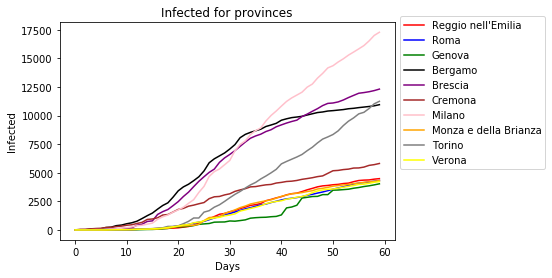

<Figure size 432x288 with 0 Axes>

In [7]:
x=len(time_line_dataset.columns[2:]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)

condition_plot(x,top_ten_list(time_line_dataset,1),['Infected','provinces'])

Milano is the most hit province for number of infected.

Some new information could be required to have a better picture.
One of this information is the total population for each city taken in exam.
We will discuss this in detail later on.
For now the graph it's aligned with what the informations that we can hear in TV and News in general are accurate.
Of course i cannot provide proof of that, but a little search on google should validate my considerations.

In [8]:
population=pd.read_csv('../Italy_analysis/dati aggiuntivi/it.csv',encoding = "ISO-8859-1")

difference =pd.Index(time_line_dataset['denominazione_provincia'].tolist()).symmetric_difference( population['index'])
population_time_line_dataset=time_line_dataset.merge(population, left_on='denominazione_provincia', right_on='index')
del population_time_line_dataset['location']
del population_time_line_dataset['google']
del population_time_line_dataset['index']

population_time_line_dataset.head()

,denominazione_regione,denominazione_provincia,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,...,20200415,20200416,20200417,20200418,20200419,20200420,20200421,20200422,20200423,population
0,Abruzzo,Chieti,0,0,0,0,0,0,0,0,...,469,499,553,566,571,606,613,648,677,44444
1,Abruzzo,L'Aquila,0,0,0,0,0,0,0,0,...,229,232,233,233,237,237,238,238,241,33691
2,Abruzzo,Pescara,0,0,0,0,0,0,0,0,...,971,1005,1042,1071,1094,1143,1190,1215,1236,116596
3,Abruzzo,Teramo,0,0,0,1,1,2,5,5,...,605,610,615,617,619,626,626,632,631,36099
4,Basilicata,Matera,0,0,0,0,0,0,0,0,...,155,169,170,172,174,174,177,181,183,54891


# Provinces considering the number of inhabitants

Since the distribution of the population for each city could give misleading information, a sample of 75000 inhabitants to even the things up was used.

I used the median factor to decide that, beacuse there are big cities that represents outliers in the population distribution and the median should not consider those outliers.



In [9]:
population_time_line_dataset['population'].median()

77241.0

Now let's redo a top ten to see if something changed from the previous approach

In [10]:
for i in range(2,len(population_time_line_dataset.columns)-1):
    column=population_time_line_dataset.columns[i]
    population_time_line_dataset[column]=(population_time_line_dataset[column]/population_time_line_dataset['population'])*75000

population_time_line_dataset.sort_values(by=[str(yesterday).replace("-", "")],ascending=False)[:10]


,denominazione_regione,denominazione_provincia,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,...,20200415,20200416,20200417,20200418,20200419,20200420,20200421,20200422,20200423,population
42,Lombardia,Cremona,0.0,66.738302,71.775155,114.588405,154.883229,171.253001,269.471634,280.804553,...,6550.427293,6639.831433,6690.199963,6808.566008,6821.158140,6914.339920,7103.221907,7185.070768,7312.251305,59561
39,Lombardia,Bergamo,0.0,11.825301,13.139223,47.301204,67.667000,72.265728,137.304883,159.641562,...,6879.697272,6909.917486,6957.218689,6982.840174,7022.257844,7054.448941,7087.296999,7126.714669,7191.096862,114162
45,Lombardia,Mantova,0.0,0.000000,0.000000,0.000000,0.000000,1.910341,7.641365,9.551707,...,5071.956190,5140.728477,5249.617932,5469.307183,5549.541518,5564.824249,5603.031075,5687.086093,5773.051452,39260
44,Lombardia,Lodi,0.0,229.965413,235.484583,292.516006,334.829642,436.014423,632.864817,706.453749,...,4759.364192,4831.113401,4926.779012,4993.009051,5011.406284,5040.841857,5061.078814,5127.308853,5211.936125,40767
40,Lombardia,Brescia,0.0,0.000000,0.811574,4.057871,5.275232,5.681019,19.883566,24.347224,...,4539.539892,4607.712118,4693.738976,4771.244305,4847.532274,4871.067923,4901.096166,4941.674873,4994.427191,184826
48,Lombardia,Pavia,0.0,30.805976,30.805976,41.074634,55.907141,62.752913,88.995041,94.699851,...,3783.430188,3867.861381,3934.037180,4034.441841,4086.926096,4154.242858,4227.264429,4333.373901,4420.087017,65734
49,Lombardia,Sondrio,0.0,3.473830,10.421491,10.421491,10.421491,10.421491,10.421491,10.421491,...,2984.020380,3001.389532,3008.337193,3254.979157,3320.981936,3334.877258,3355.720241,3515.516443,3668.364984,21590
61,Piemonte,Cuneo,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2893.937435,2931.101344,3065.214581,3194.480352,3317.282834,3352.830920,3433.622027,3528.955533,3572.582730,46416
58,Piemonte,Alessandria,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2812.879803,3015.051887,3150.612359,3216.055346,3252.282714,3289.678706,3387.843186,3515.223285,3545.607529,64178
96,P.A. Trento,Trento,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3002.797638,3071.806030,3148.274790,3199.564812,3293.751943,3347.839602,3370.220703,3400.062170,3475.598384,80425


Now let's compare the original graph with the new one,spot some differences and think about some conclusions.
Unfortunately we don't have a lot of information for provinces, a lot of invformation revolves around regions.Everything we will say could be an additional information for the regions, but as it is now, it's just speculations

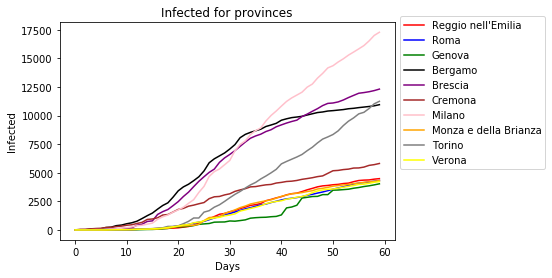

<Figure size 432x288 with 0 Axes>

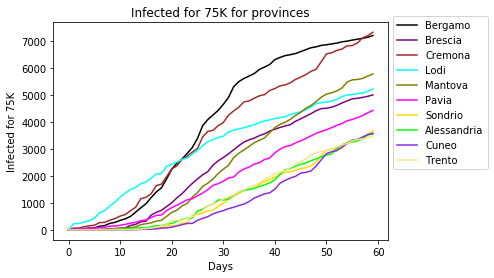

<Figure size 432x288 with 0 Axes>

In [11]:
x=len(time_line_dataset.columns[2:])
x=range(0,x)
condition_plot(x,top_ten_list(time_line_dataset,1),['Infected','provinces'])

x=len(population_time_line_dataset.columns[2:-1]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)

condition_plot(x,top_ten_list(population_time_line_dataset.loc[:,:str(yesterday).replace("-", "")],1),['Infected for 75K','provinces'])


It is possible to see a clear difference. 
While cities like Bergamo and Brescia are still in both plots, we have new cities as well, such as Lodi or Pavia in top ten.
Confronting this information with what we hear in TV, the inhabitant consideration could be more appropriate.
In TV we always hear about Bergamo being the most hit with this pandemic, and the second plot reflect that.
Most of the cities are in North Italy like we excpect since the boom of the pandemic started prom Lombardia.
We can give conclusions about regions in the next part, but for now let's say one more thing about the provinces.
Most of the provinces that are in the top ten(if not all) are huge urban metropolies,where people travel a lot every day.
It's not surprising then that the virus spread so much in those areas, considering the density of the population as well.

We can have a counter example as well. Roma has the most habitant in all italian cities, and in fact in the first plot it's present. But, from personal experience, and reliable sources, Roma is not as active as a city like Milano. There are few transports, and just 2 metros. Relaing on cars for moving, or just simple walk could be one cause of less spreading of the virus. Still there are a lot of people, so of course the virus spread a lot there as well.



# Dataset rielaboration - Regions

Create different datasets for each condition (deaths, tampons, etc.) and then plot the data. In this way, it will be easy afterward to analyze them.
First let's load the dataset, that like the provinces one, it's always up to date.
Other than that, we also load the density dataset we builded from scratch using informations on wikipedia about density population

In [14]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+str_date_formatted[0]+'.csv'
time_line_dataset_regions = pd.read_csv(url)

#adding density information from our dataset
density=pd.read_csv('../Italy_analysis/dati aggiuntivi/density.csv')
time_line_dataset_regions.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN,NaN
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2020-02-24T18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN
3,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN
4,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10,NaN,NaN,NaN


This datasets will be splitted in different datasets, one for each necessary information, like tampons information or new cases information.

First, the useless column are removed.

In [16]:
#removing useless/redundant columns
del time_line_dataset_regions['data'] #we already have data columns added in the reworking
del time_line_dataset_regions['stato'] #it's the italian database, we already know
del time_line_dataset_regions['codice_regione'] #it's an indicative value, it doesn't mean anything
del time_line_dataset_regions['ricoverati_con_sintomi'] #this column will be its own dataset
del time_line_dataset_regions['lat'] #We don't need this value knowing the city
del time_line_dataset_regions['long'] #We don't need this value knowing the city
del time_line_dataset_regions['note_it']
del time_line_dataset_regions['note_en']
del time_line_dataset_regions['casi_testati']
del time_line_dataset_regions['terapia_intensiva'] #this column will be its own dataset
del time_line_dataset_regions['totale_ospedalizzati'] #this column will be its own dataset
del time_line_dataset_regions['isolamento_domiciliare']#this column will be its own dataset
del time_line_dataset_regions['totale_positivi'] #this column will be its own dataset
del time_line_dataset_regions['nuovi_positivi']#this column will be its own dataset
del time_line_dataset_regions['dimessi_guariti']#this column will be its own dataset
del time_line_dataset_regions['variazione_totale_positivi']#this column will be its own dataset
del time_line_dataset_regions['deceduti'] #this column will be its own dataset
del time_line_dataset_regions['totale_casi'] #this column will be its own dataset
del time_line_dataset_regions['tamponi'] #this column will be its own dataset

time_line_dataset_regions.head()

,denominazione_regione
0,Abruzzo
1,Basilicata
2,P.A. Bolzano
3,Calabria
4,Campania


Columns to this tiny dataset depending on which dataset to build are added. The information in each one of this dataset are copied and then starting to add the columns.

In [17]:
#building a dataset for condition
tl_hospitalized_with_symptoms=copy.deepcopy(time_line_dataset_regions)
tl_intensive_teraphy=copy.deepcopy(time_line_dataset_regions)
tl_total_hospitalized=copy.deepcopy(time_line_dataset_regions)
tl_isolation=copy.deepcopy(time_line_dataset_regions)
tl_actual_positives=copy.deepcopy(time_line_dataset_regions)
tl_new_actual_positives=copy.deepcopy(time_line_dataset_regions)
tl_recovered=copy.deepcopy(time_line_dataset_regions)
tl_deaths=copy.deepcopy(time_line_dataset_regions)
tl_total=copy.deepcopy(time_line_dataset_regions)
tl_tampons=copy.deepcopy(time_line_dataset_regions)
tl_variance=copy.deepcopy(time_line_dataset_regions)

Every information of the columns will be exctracted from the web site so they will be always up to date, and show an example of how these datasets are.

In [18]:
#uploading every day for each dataset
for i in range(0,len(str_date_formatted)):
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+str_date_formatted[i]+'.csv'
    
    temp_data=pd.read_csv(url)
    tl_hospitalized_with_symptoms[str_date_formatted[i]]=temp_data['ricoverati_con_sintomi']
    tl_intensive_teraphy[str_date_formatted[i]]=temp_data['terapia_intensiva']
    tl_total_hospitalized[str_date_formatted[i]]=temp_data['totale_ospedalizzati']
    tl_isolation[str_date_formatted[i]]=temp_data['isolamento_domiciliare']
    tl_actual_positives[str_date_formatted[i]]=temp_data['totale_positivi']
    tl_new_actual_positives[str_date_formatted[i]]=temp_data['nuovi_positivi']
    tl_recovered[str_date_formatted[i]]=temp_data['dimessi_guariti']
    tl_deaths[str_date_formatted[i]]=temp_data['deceduti']
    tl_total[str_date_formatted[i]]=temp_data['totale_casi']
    tl_tampons[str_date_formatted[i]]=temp_data['tamponi']
    tl_variance[str_date_formatted[i]]=temp_data['variazione_totale_positivi']
tl_hospitalized_with_symptoms.head()

,denominazione_regione,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,20200303,...,20200414,20200415,20200416,20200417,20200418,20200419,20200420,20200421,20200422,20200423
0,Abruzzo,0,0,0,1,1,2,3,3,5,...,345,341,324,319,321,317,320,318,309,322
1,Basilicata,0,0,0,0,0,0,0,0,0,...,62,60,60,59,60,59,59,64,65,61
2,P.A. Bolzano,0,1,1,1,1,1,1,1,1,...,177,166,180,181,179,162,160,159,157,141
3,Calabria,0,0,0,0,0,0,0,0,0,...,161,156,157,154,152,142,140,133,128,129
4,Campania,0,0,0,2,2,3,4,4,11,...,618,607,618,622,605,590,586,532,523,539


Lastly, a new dataset for the density population is created.

In [19]:
#This one will contain the population density now on
time_line_dataset_regions=time_line_dataset_regions.merge(density, left_on='denominazione_regione', right_on='Region')
del time_line_dataset_regions['Region']

time_line_dataset_regions.head()

,denominazione_regione,Density(ab./Km^2)
0,Abruzzo,120.48
1,Basilicata,55.50
2,Calabria,127.15
3,Campania,422.25
4,Emilia-Romagna,198.62


# Dataset rielaboration - Regions Graphs

A look at each datasets plot and then trying to give some interpretations to what is showed.
Before starting, a look at the top ten density population of the regions:

In [20]:
time_line_dataset_regions.sort_values(by=['Density(ab./Km^2)'],ascending=False)[:10]


,denominazione_regione,Density(ab./Km^2)
8,Lombardia,422.76
3,Campania,422.25
6,Lazio,340.47
7,Liguria,286.30
17,Veneto,267.42
12,Puglia,205.33
4,Emilia-Romagna,198.62
14,Sicilia,192.36
11,Piemonte,171.60
15,Toscana,162.25


This information could be useful to give some conclusion on the next plots that will be analyze, so it's better to keep them in mind.

Starting with the hospitalized with symptoms, but not in grave condition.

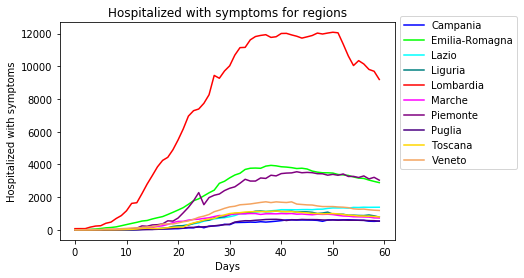

<Figure size 432x288 with 0 Axes>

In [21]:
x=len(tl_hospitalized_with_symptoms.columns[1:]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)

condition_plot(x,top_ten_list(tl_hospitalized_with_symptoms,0),['Hospitalized with symptoms','regions'])

Lombardia is one of the most affected regions, but this is expected.
New sites and TV always referes to that, so there is nothing new.
Based on what did before, it is safe to say that most of the cities within Lombardia are the most affected, so computing these results, Lombardia will come on top for the most hit region by the virus.
While this datasets revolves around the hospitalized people, another conclusion can be done.

Lombardia has the most advanced hospitals in all Italy, so naturally most of the people are here because there are a lot of experts in the matter or in their part of Italy, there are not Hospitals that can sustain them.
One example, in example, with a quick google search, Napoli has a huge problem with hospitals. They are in bad state, and the medical staff doesn't work properly (in general, not every single one of them.). So it's likely that the people want to go to a better hospital or just don't go there. In the top ten ranking, Campania is the last one in fact even if the density population it's really high.

Although there are 20 regions, and not everyone appears, but those regions are really small, so the amount of hospitals could be really small, forcing them to go elsewhere.

It is possible at least to say that the curve is reducing, toward a better perspective.

Next step is to have a look on intensive therapy.

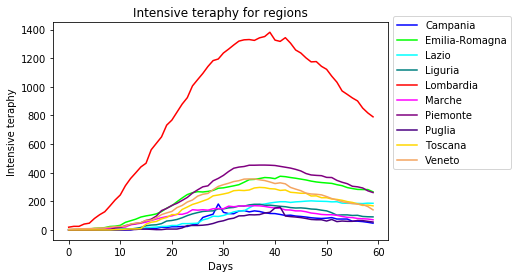

<Figure size 432x288 with 0 Axes>

In [22]:
condition_plot(x,top_ten_list(tl_intensive_teraphy,0),['Intensive teraphy','regions'])

The situation is almost exactly the same as before. The discussion is the same: more and qualitative hospitals are in northen region of the Italy. Naturally most of the people want to be cured by specialist, or if other hospitals don't have enough space, in Lombardia and such there are a lot of hospitals (unfortunately not enough for this pandemic).
One example could be the center of intensive therapy now opened in Rho, in place of the Expo. Since in Lombardia there are a lot of hospitals (even new ones made just for this pandemic), there are more patients than the available places. Of course density of the population is a factor as well.

Next step is to have a look at the deaths.

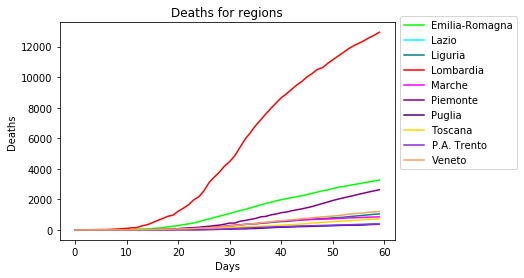

<Figure size 432x288 with 0 Axes>

In [23]:
condition_plot(x,top_ten_list(tl_deaths,0),['Deaths','regions'])

While Lombardia is on top again, almost every other region is different.
Being that the most of the ill are in Lombardia, it's not surprising that the most amount of deaths is here as well.
Lazio and Toscana could also be in the top ranking because the amount of the population.
The new one here are Marche, and Trentino alto adige. While it's difficul to pin point why this is like this, one possibility is that the lockdown in those regions was a bit further in the line.
The interesting to see though, it's about the dates.
Lombardia sky rocketted with deaths in hust 10-20 days going as far as 12000+ deaths. The other regions don't have this amount of deaths.
The logical explanation is that for a couple of weeks, only Lombardia had COVID cases, while the other regions didn't.
When the virus then arrived in those regions, precautions where already made, so less people died.

Next step is to have a look to the isolations.

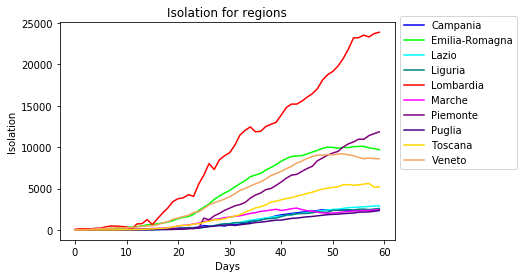

<Figure size 432x288 with 0 Axes>

In [24]:
condition_plot(x,top_ten_list(tl_isolation,0),['Isolation','regions'])

This graphs doesn't really suggest nothing interesting. Of course more and more people get confined due to the laws made for this pandemic.
The interesting thing though, is that it is possible to see that the lines sometimes goes down. A deduction can be made: a lot of italians are just irresponsible, and get out anyways despite the law.

Next step is to have a look at the actual postives.

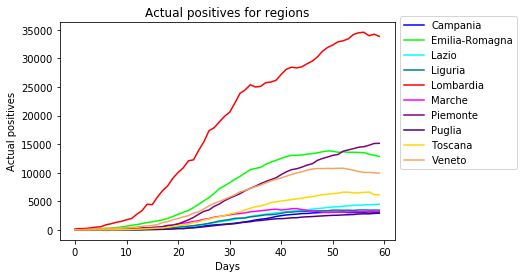

<Figure size 432x288 with 0 Axes>

In [25]:
condition_plot(x,top_ten_list(tl_actual_positives,0),['Actual positives','regions'])

Nothing interesting to say here as well, the more hospitalized, the more positives we have.
One thing to note is that the positives are not decreasing, while the hospitilized are.
This could be that a lot of people are asintomatic, and so, they don't need to be in the hospital.
Doing a ratio between hospitalized and poitives could hint a rough amount of the asintomatic for region.

Next plot shows how the positive rate is growing.

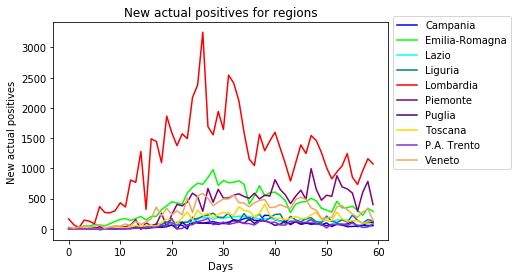

<Figure size 432x288 with 0 Axes>

In [26]:
condition_plot(x,top_ten_list(tl_new_actual_positives,0),['New actual positives','regions'])

This plot is really fuzzy. This is propably due to the fact that not every day there are new positives.
Before analyzing it, last plot can be stabilized applying a moving average on the value.

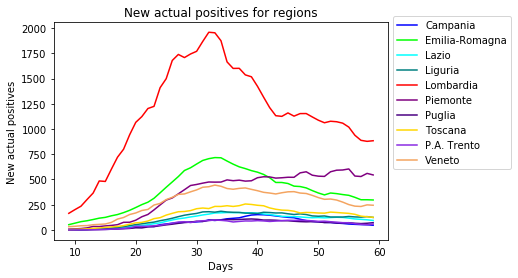

<Figure size 432x288 with 0 Axes>

In [27]:
x2=len(tl_hospitalized_with_symptoms.columns[1:]) 
x2=range(9,x2) #Starting index is in regars of the window frame of the moving mean, in this case 10 (0 to 9)

moving_averages_NPositive=moving_mean_with_names(top_ten_list(tl_new_actual_positives,0),10)
moving_averages_variance=moving_mean_with_names(top_ten_list(tl_variance,0),10)
condition_plot(x2,moving_averages_NPositive,['New actual positives','regions'])
#condition_plot(x2,moving_averages_variance,['Variance total positives','regions'])

It is possible to see that the new postives are decreasing more and more.
The fact that the actual positives are on an higher value it's just because once someone is positive, the illness will last for a couple of weeks.
Since around day 30, the lockdown started for everyone so the graph displays that new positives are decreasing. The countermeasure taken by the government seems to work pretty fine.

Next step is to have a look at the recovered people.

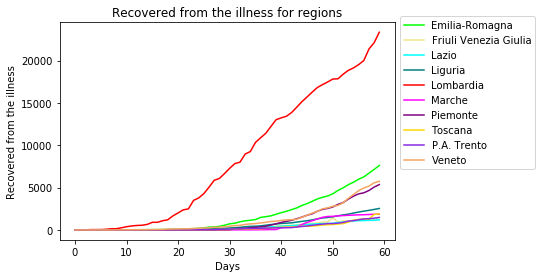

<Figure size 432x288 with 0 Axes>

In [28]:
condition_plot(x,top_ten_list(tl_recovered,0),['Recovered from the illness','regions'])

The recovery from the illness is not related to the lockdown, since once you have the illness, it has to pass on its own.
There is not much to analyze here, only that where there is a peak of recovered (around 50-60 days), the amount of hospitilez decreases.

Next a plot about the number of tampons.

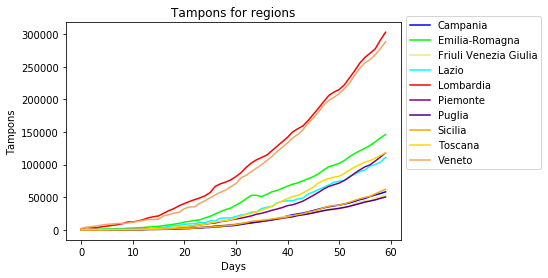

<Figure size 432x288 with 0 Axes>

In [29]:
condition_plot(x,top_ten_list(tl_tampons,0),['Tampons','regions'])

On the curve itself there is not much to say, the tampons are growing exponentially every day, beacuse there is the necessity to do the most amount of them for isolating positive people. The interesting thing to analyze are the regions.
Veneto is on the same level of the Lombardia.
This is beacuse news and TV said that Veneto started to use them before the pandemic even began. It's not surpirsing to see them like that.
Another thing that it is possible to see is that with all these tampons done, Veneto has not a lot of positives, hospitalized and everything saw up until now. This data enforces the thesis about the importance in executing tampons to isolate as soon as possible positive people.
That's possible beacuse stricter investigations where done, and the spreading of the virus reduced a lot in respect of other regions.

One final look at the total of cases(recovered and not).

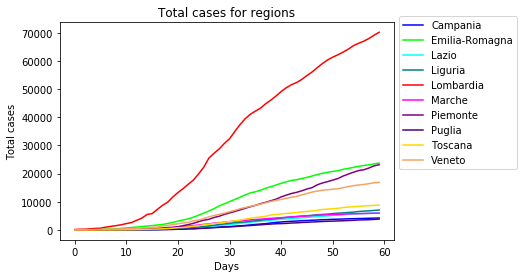

<Figure size 432x288 with 0 Axes>

In [30]:
condition_plot(x,top_ten_list(tl_total,0),['Total cases','regions'])

Everything said up until now stands.
There is nothing to say about this plot but as a matter of fact, it is possible to see that every single region with the greater number of infected, is in the list of the most density population list.
It's not a perfect match, because even though Lombardia is in the first place of both the density and almost every plots, other regions are not. 
In example, Campania occupies the second place of the population density ranking, but it's one of the lower displayed in the actual positive graph and a hypothesis has been done why this could be the case.
More than one factor could concern this aspect, such as the date of lockdown, or the population behavior, but it seems that the density population helped the diffusion of the virus as well. 

It is possible to see that the total cases are really high and there are not stabilizing yet.
When the lines will be parallel to the X axis, we could say that finally the illness it's under control.
Sadly, Lombardia trend is nowhere near to be flat, but other regions like Emilia-Romagna could give some brim of hope for the near future.

# ARIMA model

In [ ]:
###### IN THE FUTURE

model = ARIMA(???, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())